<a href="https://colab.research.google.com/github/pony-yyy/GroupWork/blob/main/Restaurant_in_PA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Authenticate and access Google Cloud services
from google.colab import auth
auth.authenticate_user()

In [2]:
# Import the necessary libraries
from google.cloud import storage
from google.cloud import bigquery

project_id = "bdao-ima-422711"
dataset_name = "bobbdaoima"
table_name = "restaurant_tips" # if you make changes previously, then here you need to make according change

bigquery_client = bigquery.Client(project=project_id)

In [ ]:
# Query all data from the table
query = f"""
  SELECT
  b.business_id,
  t.text AS review
FROM
  `{project_id}.{dataset_name}.All_data_cleaned` b
INNER JOIN
  `{project_id}.{dataset_name}.restaurant_tips` t
ON
  b.business_id = t.business_id
WHERE
  b.state = 'PA';

"""

query_job = bigquery_client.query(query)
results = query_job.result()

reviewInPa_df = query_job.to_dataframe()
reviewInPa_df

In [ ]:
import pandas as pd
from textblob import TextBlob
import numpy as np

target_column = 'review'

reviewInPa_df['Polarity'] = reviewInPa_df[target_column].apply(lambda review: TextBlob(str(review)).sentiment.polarity)
reviewInPa_df['Subjectivity'] = reviewInPa_df[target_column].apply(lambda review: TextBlob(str(review)).sentiment.subjectivity)

reviewInPa_df['Sentiment'] = np.where(reviewInPa_df['Polarity'] > 0, 'Positive', np.where(reviewInPa_df['Polarity'] < 0, 'Negative', 'Neutral'))

reviewInPa_df

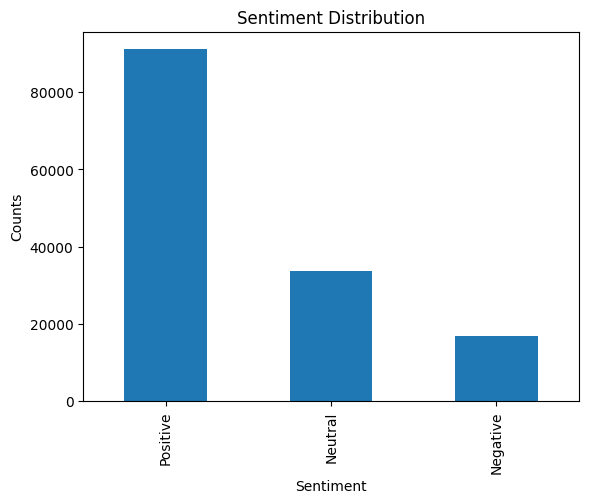

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

sentiment_counts = reviewInPa_df['Sentiment'].value_counts()

sentiment_counts.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.show()

In [ ]:
positive_reviews = reviewInPa_df[reviewInPa_df['Sentiment'] == 'Positive']

positive_review_counts = positive_reviews.groupby('business_id').size()

top_10_positive_businesses = positive_review_counts.sort_values(ascending=False).head(10)

print(top_10_positive_businesses)

In [19]:
top_10_positive_businesses_df = top_10_positive_businesses.reset_index()
top_10_positive_businesses_df.columns = ['business_id', 'positive_review_count']

print(top_10_positive_businesses_df)

              business_id  positive_review_count
0  ytynqOUb3hjKeJfRj5Tshw                    555
1  RQAF6a0akMiot5lZZnMNNw                    358
2  qY-BUQY-SFBaSrFHowF3nA                    244
3  AGlh4ZDv6jnoiYfz7At9mw                    239
4  ctHjyadbDQAtUFfkcAFEHw                    220
5  PP3BBaVxZLcJU54uP_wL6Q                    207
6  9PZxjhTIU7OgPIzuGi89Ew                    197
7  sTPueJEwcRDj7ZJmG7okYA                    195
8  6ajnOk0GcY9xbb5Ocaw8Gw                    179
9  8pqdJjefYq-a9IBSJJmKwA                    176


In [ ]:
# Import the necessary libraries
from google.cloud import storage
from google.cloud import bigquery

project_id = "bdao-ima-422711"
dataset_name = "bobbdaoima"
table_name = "restaurant_data" # if you make changes previously, then here you need to make according change

bigquery_client = bigquery.Client(project=project_id)

# Query all data from the table
query = f"""
   SELECT business_id,categories
   FROM `{project_id}.{dataset_name}.{table_name}`;

"""

query_job = bigquery_client.query(query)
results = query_job.result()

categories_df = query_job.to_dataframe()
categories_df

In [ ]:
categories_in_top_10_businesses = pd.merge(top_10_positive_businesses_df, categories_df, on='business_id', how='inner')
categories_in_top_10_businesses

In [ ]:
pip install wordcloud

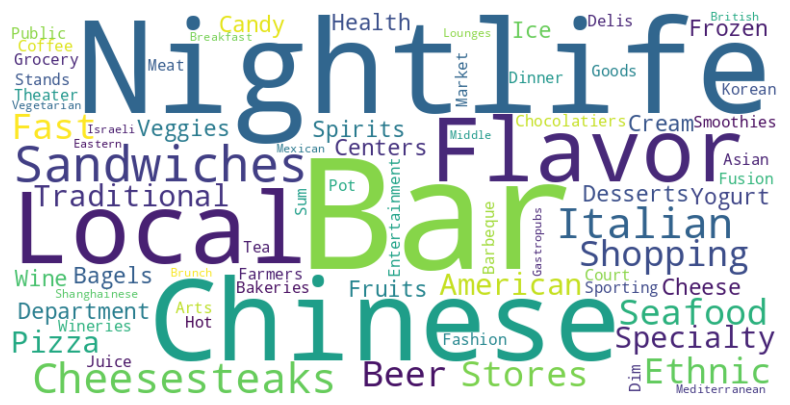

In [29]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter

text = ' '.join(category for category in categories_in_top_10_businesses['categories'])

custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['Restaurants', 'Food', 'Restaurant',"&","Markets","Shops"])


cleaned_words = [word for word in text.split() if word not in custom_stopwords]

word_counts = Counter(cleaned_words)

sorted_words = word_counts.most_common()

# for word, count in sorted_words:
#     print(f"{word}: {count}")

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
